# Analýza zaměstnanosti v regionech EU (Eurostat)

Tento notebook obsahuje analýzu dat o zaměstnanosti v regionech vybrané evropské země na základě datové sady **Eurostatu** (nama_10r_3empers).  

## Cíl analýzy
- Získat a zpracovat údaje o **počtu zaměstnaných osob** v jednotlivých **regionech (NUTS 3)**.  
- Agregovat ekonomické činnosti do širších kategorií podle klasifikace **NACE**.  
- Zaměřit se na hodnoty za rok **2022** (případně nejbližší dostupný rok).  

## Struktura analýzy
1. **Načtení a zpracování dat** z Eurostatu  
2. **Agregace ekonomických kategorií** (A-F, G-J, K-N, O-U)  
3. **Vizualizace a interpretace výsledků**
   

In [50]:
library(eurostat)
library(vtable)
library(ggplot2)
library(reshape2)

In [3]:
search <- search_eurostat(pattern="Employment (thousand persons) by NUTS 3 region")

In [4]:
code <- "nama_10r_3empers"

In [5]:
suppressMessages({
    data <- get_eurostat(id = code, time_format = "num")
})
head(data)

freq,unit,wstatus,nace_r2,geo,TIME_PERIOD,values
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
A,THS,EMP,A,AT,2000,230.7
A,THS,EMP,A,AT,2001,229.6
A,THS,EMP,A,AT,2002,225.5
A,THS,EMP,A,AT,2003,224.9
A,THS,EMP,A,AT,2004,218.0
A,THS,EMP,A,AT,2005,215.0


## Struktura datasetu

Dataset obsahuje informace o **zaměstnanosti (v tisících osob) podle regionů NUTS 3** v Evropě.  
Níže jsou uvedeny hlavní sloupce datové sady:

- **freq** – frekvence sběru dat (vždy „A“ = roční data).  
- **unit** – jednotka měření (vždy „THS“ = tisíce osob).  
- **wstatus** – pracovní status 
- **nace_r2** – sektor ekonomické činnosti podle klasifikace NACE.  
- **geo** – geografický kód regionu (např. „AT“ = Rakousko).  
- **TIME_PERIOD** – rok, ke kterému se data vztahují.  
- **values** – počet zaměstnaných osob (v tisících).  

Tento dataset umožňuje analyzovat zaměstnanost v různých regionech a ekonomických sektorech v průběhu času.  


## Filtering

In [49]:
library(dplyr)
library(stringr)

data_pt_22 <- data %>%
    filter(str_starts(geo, "PT") & nchar(geo) == 5 & TIME_PERIOD == 2022 & wstatus == "EMP")

In [7]:
head(data_pt_22)


freq,unit,wstatus,nace_r2,geo,TIME_PERIOD,values
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
A,THS,EMP,A,PT111,2022,7.52
A,THS,EMP,A,PT112,2022,8.81
A,THS,EMP,A,PT119,2022,6.01
A,THS,EMP,A,PT11A,2022,18.72
A,THS,EMP,A,PT11B,2022,6.83
A,THS,EMP,A,PT11C,2022,7.73


In [8]:
unique(data_pt_22$geo)


[1] "PT111" "PT112" "PT119" "PT11A" "PT11B" "PT11C" "PT11D" "PT11E" "PT150"
[10] "PT191" "PT192" "PT193" "PT194" "PT195" "PT196" "PT1A0" "PT1B0" "PT1C1"
[19] "PT1C2" "PT1C3" "PT1C4" "PT1D1" "PT1D2" "PT1D3" "PT200" "PT300" "PTZZZ"

V původních datech byly regiony označeny **NUTS kódy**, což není příliš přehledné.  
Proto provádíme **sloučení datasetu** s tabulkou názvů regionů (`nuts_names`), aby se místo kódů zobrazovala **čitelná jména**.  


In [9]:
nuts_names <- get_eurostat_dic("geo")

data_pt_22 <- merge(data_pt_22, nuts_names, by.x = "geo", by.y = "code_name")
head(data_pt_22)

,geo,freq,unit,wstatus,nace_r2,TIME_PERIOD,values,full_name
,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>
1,PT111,A,THS,EMP,A,2022,7.52,Alto Minho
2,PT111,A,THS,EMP,M_N,2022,8.24,Alto Minho
3,PT111,A,THS,EMP,R-U,2022,5.85,Alto Minho
4,PT111,A,THS,EMP,TOTAL,2022,103.75,Alto Minho
5,PT111,A,THS,EMP,O-Q,2022,22.15,Alto Minho
6,PT111,A,THS,EMP,G-J,2022,23.52,Alto Minho


Teď už máme regiony **v lidsky čitelné podobě**, což usnadní analýzu i vizualizaci. 

In [10]:
unique(data_pt_22$wstatus)
unique(data_pt_22$unit)


[1] "EMP"

[1] "THS"

In [11]:
unique(data_pt_22$nace_r2)


[1] "A"     "M_N"   "R-U"   "TOTAL" "O-Q"   "G-J"   "O-U"   "K-N"   "K"    
[10] "B-E"   "J"     "G-I"   "C"     "F"     "L"

In [12]:
data_pt_22 <- data_pt_22 %>%
  mutate(
    nace_range = case_when(
      nace_r2 %in% c("A", "B-E", "C", "F") ~ "A-F",
      nace_r2 %in% c("G-I", "G-J", "J") ~ "G-J",
      nace_r2 %in% c("K", "K-N", "L", "M_N") ~ "K-N",
      nace_r2 %in% c("O-Q", "O-U", "R-U") ~ "O-U",
      nace_r2 == "TOTAL" ~ "TOTAL"
    ),
    nace_category = case_when(
      nace_r2 %in% c("A", "B-E", "C", "F") ~ "zemědělství, průmysl, stavebnictví",
      nace_r2 %in% c("G-I", "G-J", "J") ~ "Maloobchod, doprava, ubytování, stravování",
      nace_r2 %in% c("K", "K-N", "L", "M_N") ~ "ICT, finančnictví",
      nace_r2 %in% c("O-Q", "O-U", "R-U") ~ "veřejný sektor (administrativa, školství, zdravotnictví)",
      nace_r2 == "TOTAL" ~ "TOTAL"
    )
  )

unique(data_pt_22[, c("nace_range", "nace_category")])


,nace_range,nace_category
,<chr>,<chr>
1,A-F,"zemědělství, průmysl, stavebnictví"
2,K-N,"ICT, finančnictví"
3,O-U,"veřejný sektor (administrativa, školství, zdravotnictví)"
4,TOTAL,TOTAL
6,G-J,"Maloobchod, doprava, ubytování, stravování"


Smazeme vsechny sloupce, ktere maji stejnou hodnotu pro vsechny datove body

In [13]:
data_pt_22 <- subset(data_pt_22, select = -c(freq, TIME_PERIOD, unit, wstatus))

data_pt_22$geo <- as.factor(data_pt_22$geo)
data_pt_22$nace_r2 <- as.factor(data_pt_22$nace_r2)
head(data_pt_22)

,geo,nace_r2,values,full_name,nace_range,nace_category
,<fct>,<fct>,<dbl>,<chr>,<chr>,<chr>
1,PT111,A,7.52,Alto Minho,A-F,"zemědělství, průmysl, stavebnictví"
2,PT111,M_N,8.24,Alto Minho,K-N,"ICT, finančnictví"
3,PT111,R-U,5.85,Alto Minho,O-U,"veřejný sektor (administrativa, školství, zdravotnictví)"
4,PT111,TOTAL,103.75,Alto Minho,TOTAL,TOTAL
5,PT111,O-Q,22.15,Alto Minho,O-U,"veřejný sektor (administrativa, školství, zdravotnictví)"
6,PT111,G-J,23.52,Alto Minho,G-J,"Maloobchod, doprava, ubytování, stravování"


In [14]:
colSums(is.na(data_pt_22))

geo       nace_r2        values     full_name    nace_range 
            0             0             0             0             0 
nace_category 
            0

In [15]:
dim(data_pt_22)


[1] 393   6

Nejdůležitější statistické míry, které data nejlépe charakterizují:

- summary (pro mean, median, kvartily)

- rozptyl 

In [16]:
summary(data_pt_22$values)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.11    3.59   11.97   37.34   32.75 1295.58 

In [17]:
var(data_pt_22$values)


[1] 9166.4

## Porovnání zaměstnanosti mezi regiony  

Graf zobrazuje **celkový počet zaměstnaných osob** v jednotlivých regionech (NUTS 3).  

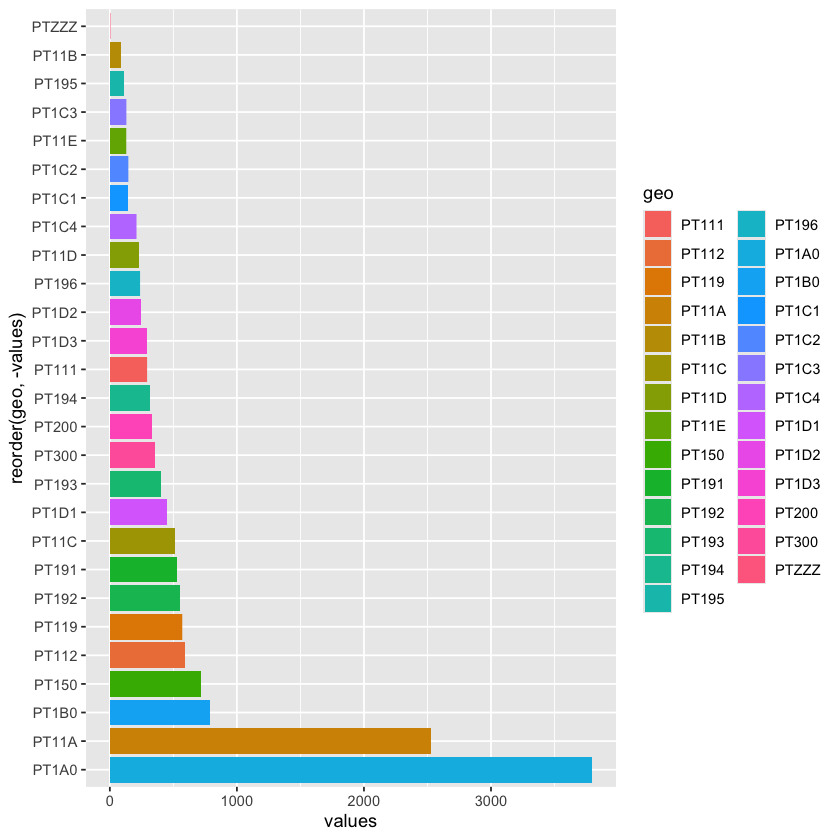

In [18]:
ggplot(data_pt_22, aes(x = reorder(geo, -values), y = values, fill = geo)) +
  geom_bar(stat = "identity") +
  coord_flip()

## Rozdělení zaměstnanosti podle kategorií zaměstnání (NACE)  

Boxplot znázorňuje **rozložení počtu zaměstnaných osob** v jednotlivých kategoriích zaměstnání (NACE) v regionech Portugalska pro rok 2022.  


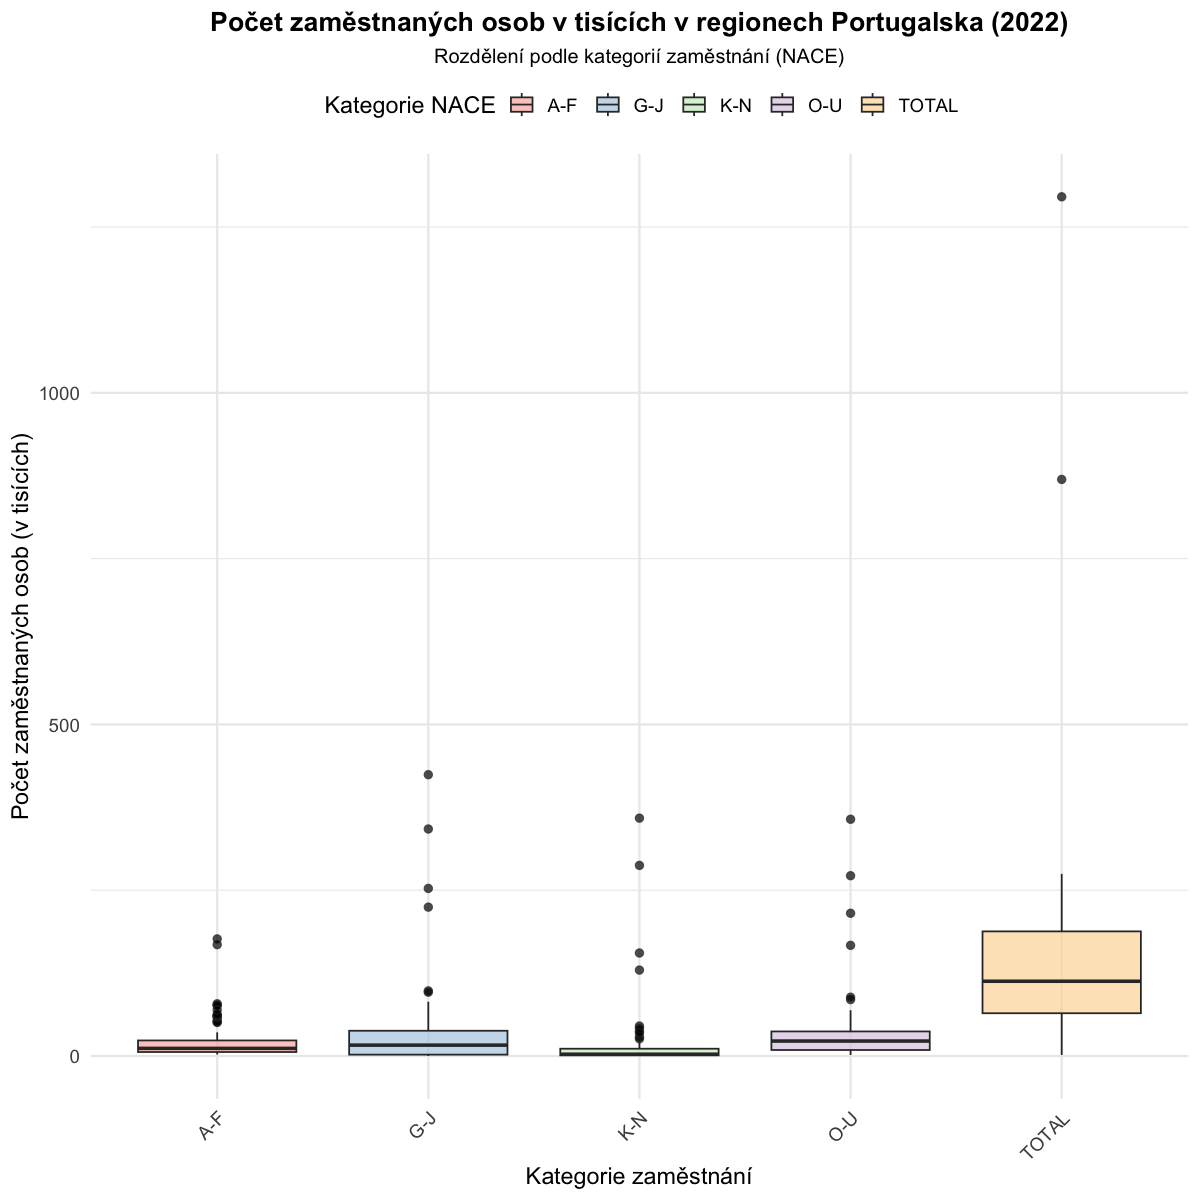

In [19]:
library(repr)

options(repr.plot.width = 10, repr.plot.height = 10)

ggplot(data_pt_22, aes(x = nace_range, y = values, fill = nace_range)) +
    geom_boxplot(outlier.shape = 21, outlier.fill = "black", outlier.size = 2, alpha = 0.7) +
    scale_fill_brewer(palette = "Pastel1") +
    labs(
        title = "Počet zaměstnaných osob v tisících v regionech Portugalska (2022)",
        subtitle = "Rozdělení podle kategorií zaměstnání (NACE)",
        x = "Kategorie zaměstnání",
        y = "Počet zaměstnaných osob (v tisících)",
        fill = "Kategorie NACE"
    ) +
    theme_minimal(base_size = 14) +
    theme(
        plot.title = element_text(face = "bold", size = 16, hjust = 0.5),
        plot.subtitle = element_text(size = 12, hjust = 0.5),
        axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1),
        legend.position = "top"
    )


## Celkový počet zaměstnaných osob podle regionů  

Tento **horizontální sloupcový graf** zobrazuje **celkový počet zaměstnaných osob v jednotlivých regionech** (NUTS 3) v roce 2022.  


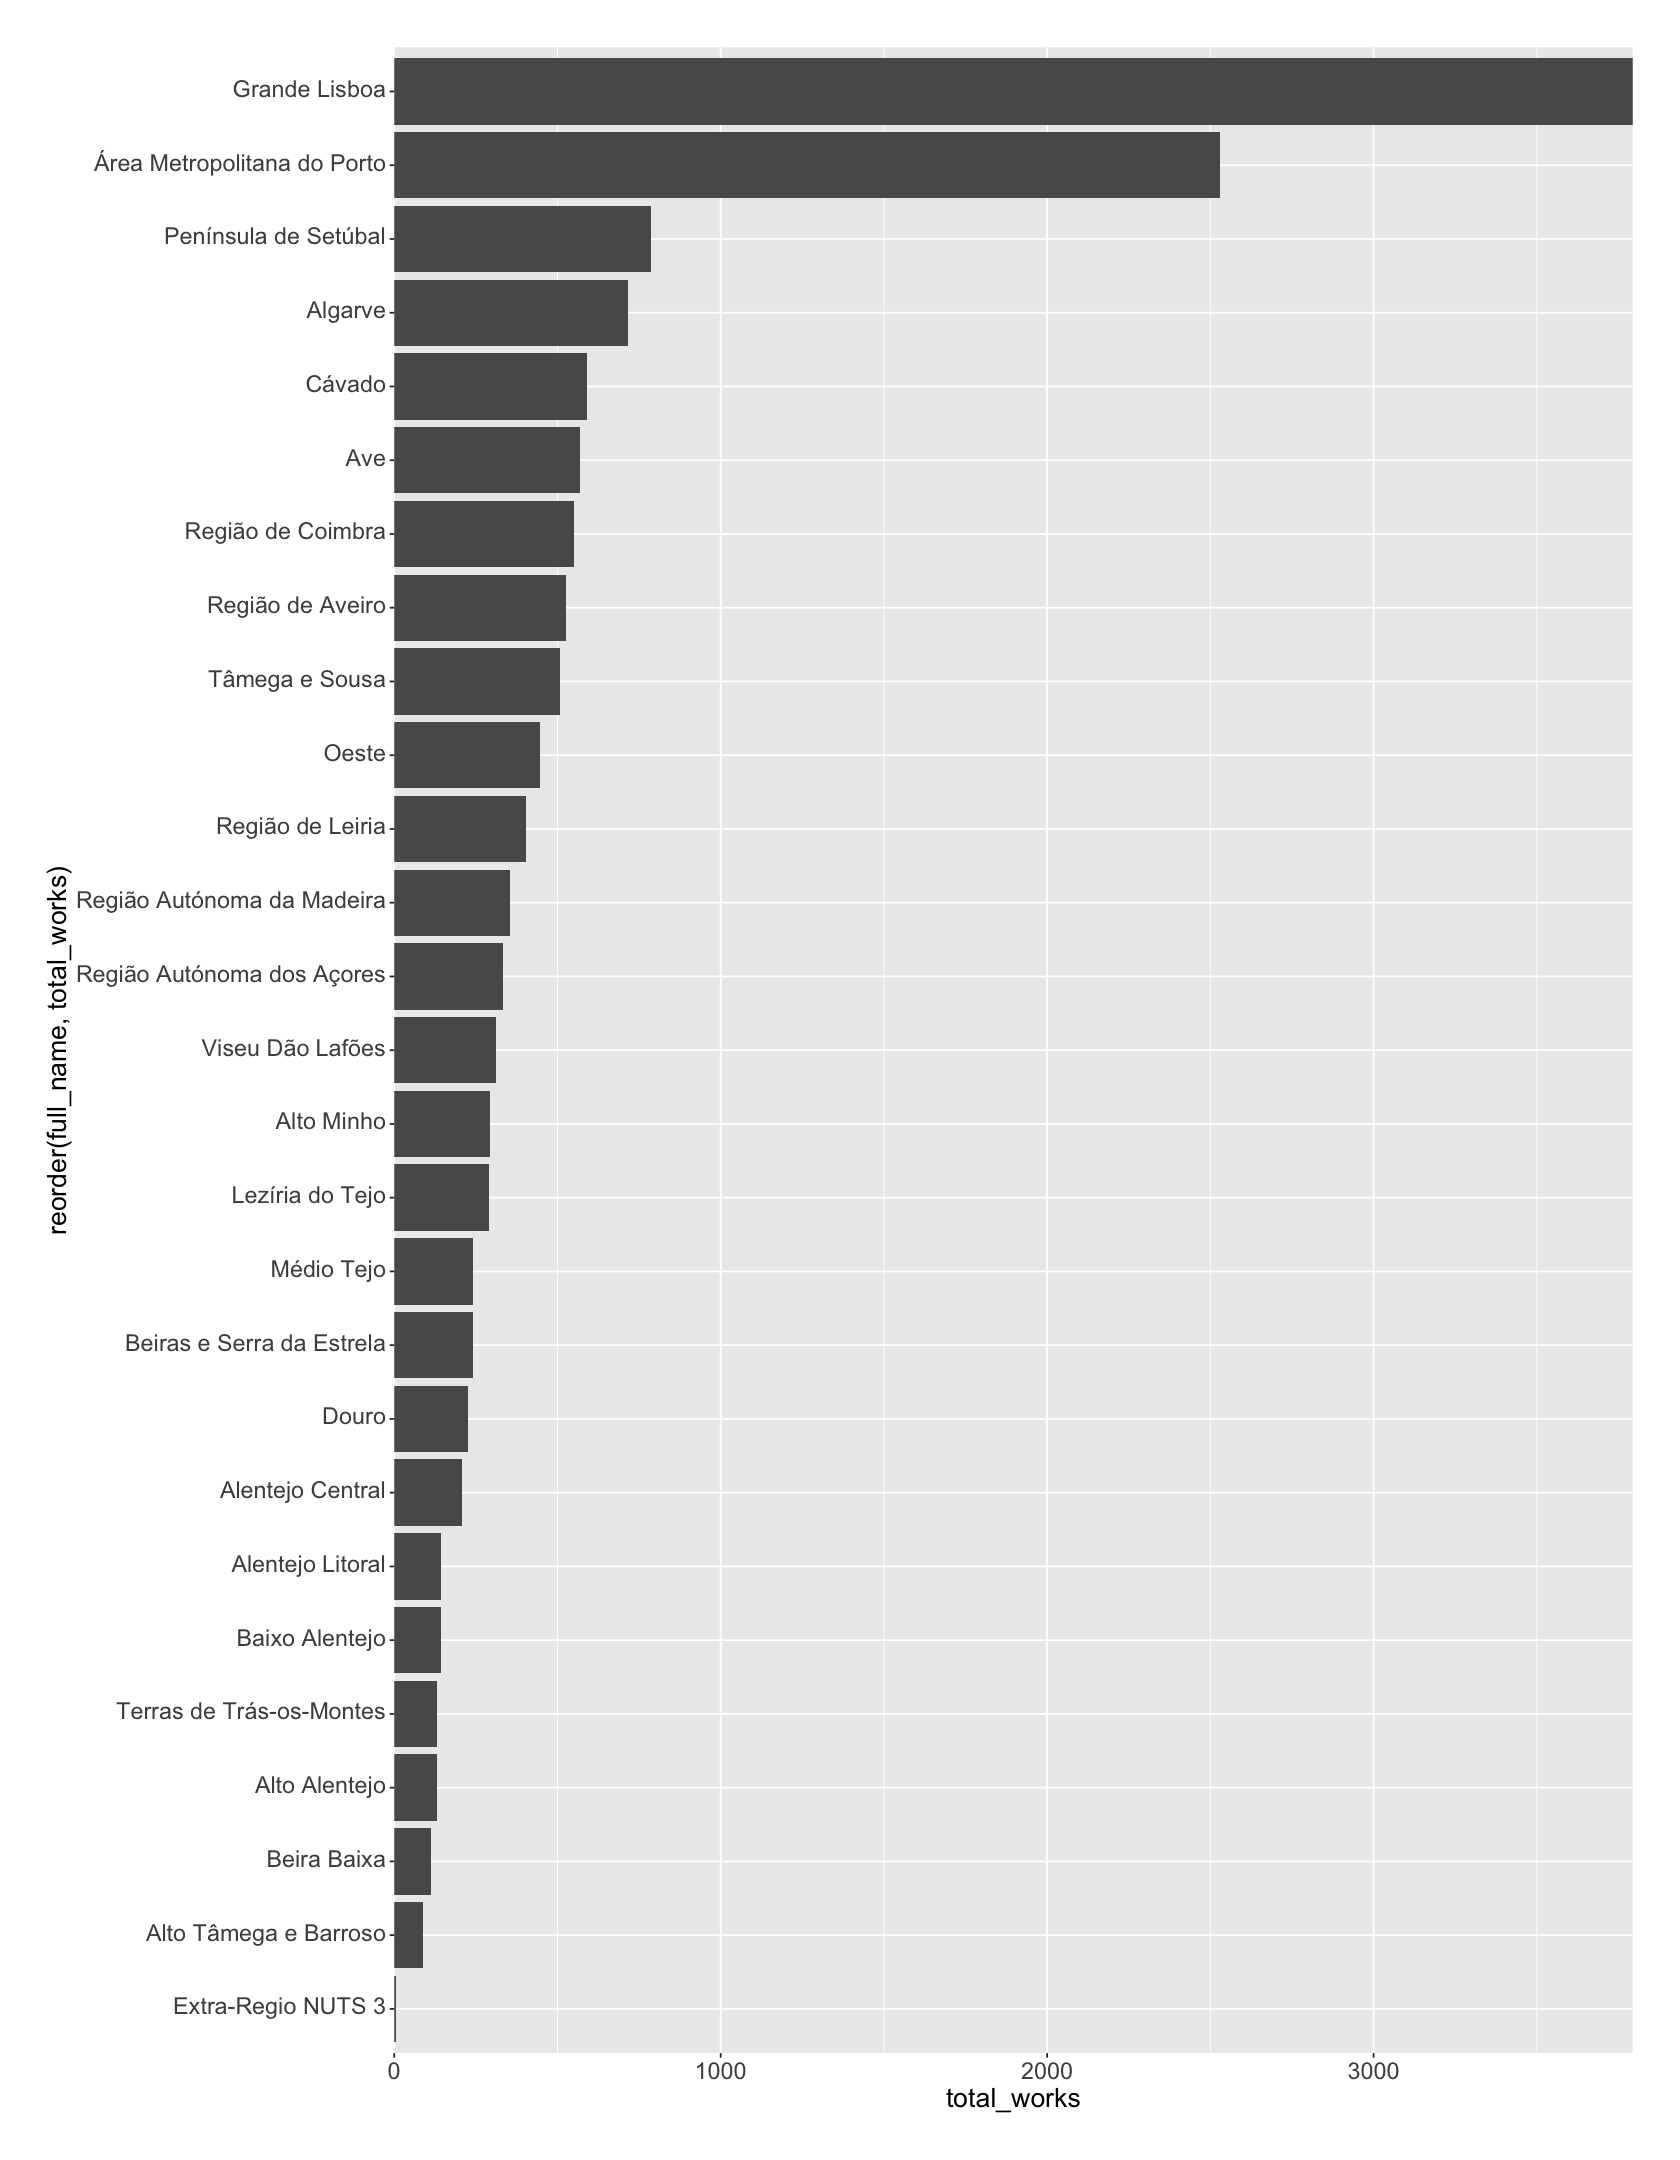

In [31]:
options(repr.plot.width = 14, repr.plot.height = 18)

works_per_region_full_name <- data_pt_22 %>%
    group_by(full_name) %>%
    summarize(total_works = sum(values))

ggplot(works_per_region_full_name, aes(y = reorder(full_name, total_works), x = total_works)) +
    geom_bar(stat = "identity") +
    scale_x_continuous(expand = c(0, 0)) +
    theme(
        axis.text.x = element_text(angle = 0, hjust = 0.5, size = 14),
        axis.text.y = element_text(size = 14, vjust = 0.3),
        axis.title = element_text(size = 16),
        plot.title = element_text(size = 20, hjust = 0.4, face = "bold"),
        plot.margin = margin(1, 1, 1, 1, "cm")
    )

Zajímavé je region Extra-Regio NUTS 3, označovaný jako PTZZZ, což jsou oblasti, které nejsou geograficky přiřazeny k žádné konkrétní NUTS 3 oblasti, ale přesto generují ekonomickou aktivitu.

## Analýza vývoje zaměstnanosti v odvětví "Maloobchod, doprava, ubytování, stravování"

Cílem této analýzy je **zhodnotit vývoj zaměstnanosti v tomto odvětví** za poslední dvě desetiletí (2000–2022). Pomocí grafu budeme schopni identifikovat klíčové trendy, období růstu a poklesu, a také pochopit, jaké faktory mohly tyto změny ovlivnit.

### Co graf ukazuje?

Graf zobrazuje **celkový počet zaměstnanců** v odvětví "Maloobchod, doprava, ubytování, stravování" v průběhu let 2000–2022. Na ose X jsou uvedeny roky, zatímco na ose Y je znázorněn počet zaměstnanců. Graf je založen na oficiálních datech a umožňuje identifikovat následující:

- **Růstové období**: Kdy a jak rychle zaměstnanost rostla.
- **Poklesy**: Kdy došlo k poklesu zaměstnanosti a jak výrazný byl.
- **Stabilita**: Období, kdy zaměstnanost zůstávala relativně konstantní.

### Klíčové otázky, na které graf odpovídá:
1. Jak se změnila zaměstnanost v tomto odvětví za posledních 20 let?
2. Která období byla nejúspěšnější a která naopak přinesla výzvy?
3. Jaké vnější faktory mohly ovlivnit vývoj zaměstnanosti?

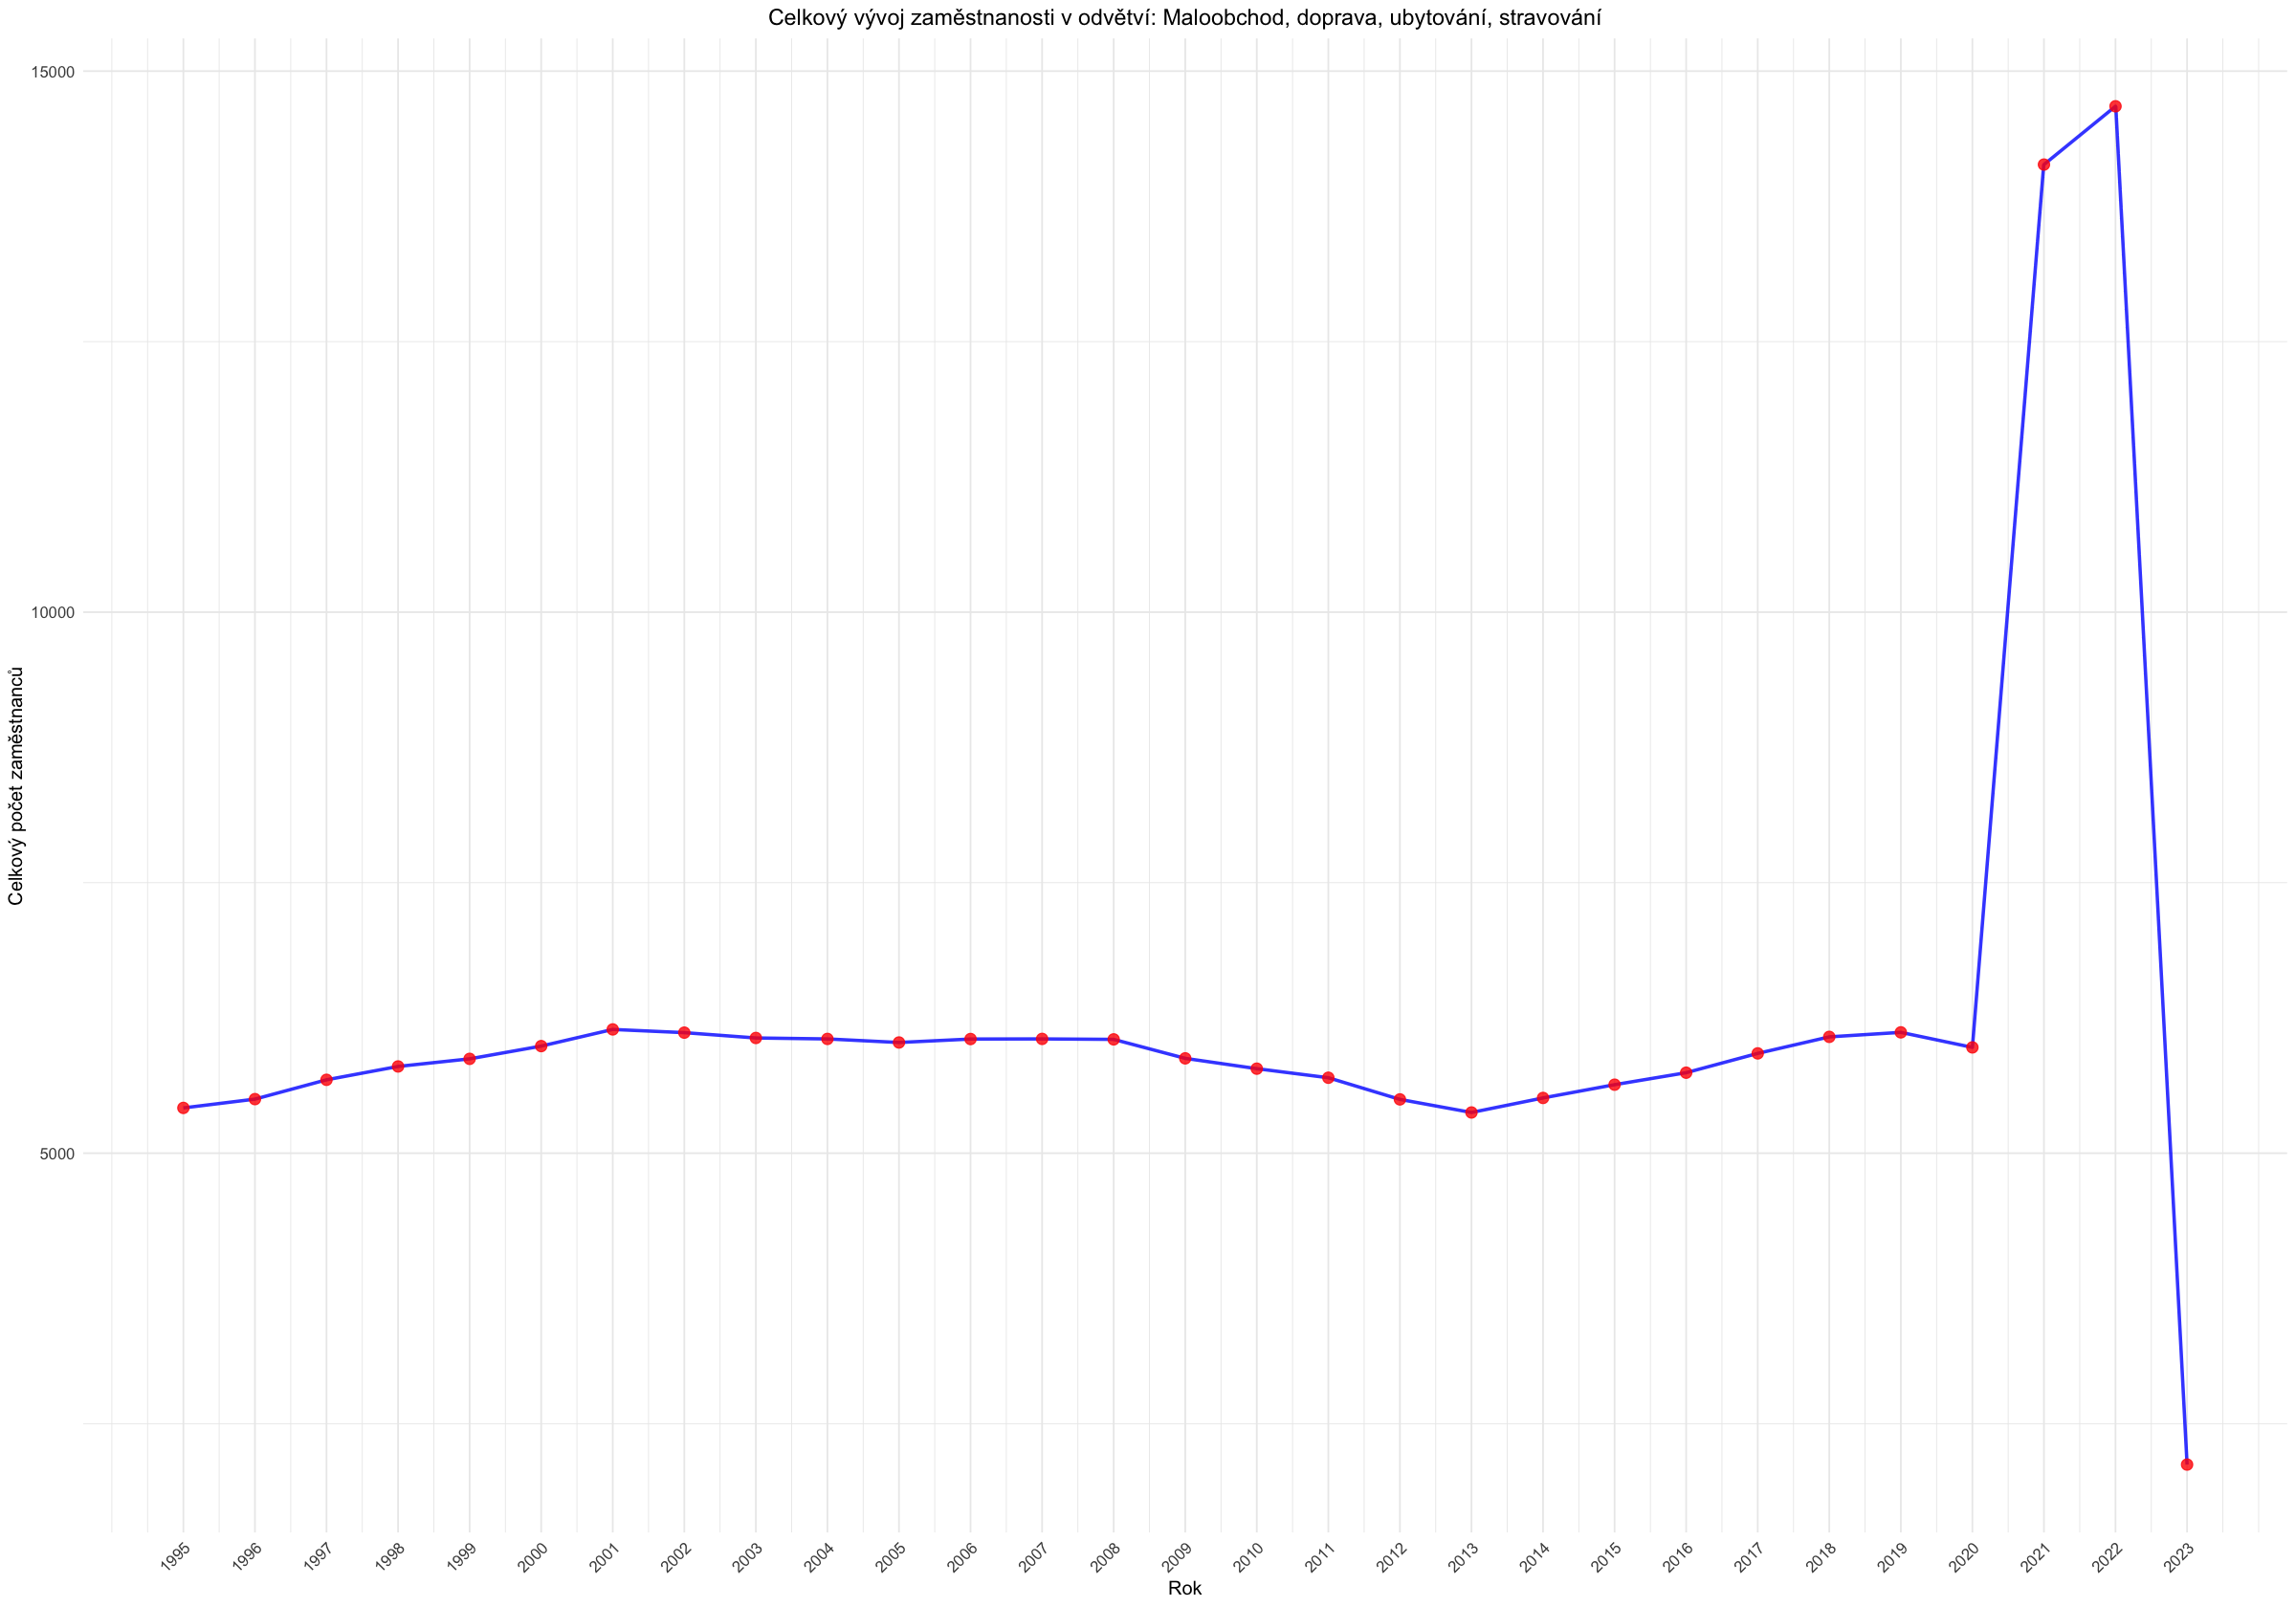

In [47]:
library(ggplot2)
library(dplyr)

odvetvi_filtrovane <- "Maloobchod, doprava, ubytování, stravování"

data_filtered <- data %>%
  filter(str_starts(geo, "PT") & nchar(geo) == 5 & wstatus == "EMP")

data_filtered <- merge(data_filtered, nuts_names, by.x = "geo", by.y = "code_name")

data_filtered <- data_filtered %>%
  mutate(
    nace_range = case_when(
      nace_r2 %in% c("A", "B-E", "C", "F") ~ "A-F",
      nace_r2 %in% c("G-I", "G-J", "J") ~ "G-J",
      nace_r2 %in% c("K", "K-N", "L", "M_N") ~ "K-N",
      nace_r2 %in% c("O-Q", "O-U", "R-U") ~ "O-U",
      nace_r2 == "TOTAL" ~ "TOTAL"
    ),
    nace_category = case_when(
      nace_r2 %in% c("A", "B-E", "C", "F") ~ "zemědělství, průmysl, stavebnictví",
      nace_r2 %in% c("G-I", "G-J", "J") ~ "Maloobchod, doprava, ubytování, stravování",
      nace_r2 %in% c("K", "K-N", "L", "M_N") ~ "ICT, finančnictví",
      nace_r2 %in% c("O-Q", "O-U", "R-U") ~ "veřejný sektor (administrativa, školství, zdravotnictví)",
      nace_r2 == "TOTAL" ~ "TOTAL"
    )
  )

data_filtered <- subset(data_filtered, select = -c(freq, unit, wstatus))

data_summarized <- data_filtered %>%
  group_by(TIME_PERIOD) %>%
  summarise(total_values = sum(values, na.rm = TRUE))


options(repr.plot.width = 20, repr.plot.height = 14)


ggplot(data_summarized, aes(x = TIME_PERIOD, y = total_values)) +
  geom_line(linewidth = 1, color = "blue", alpha = 0.8) +  # Линия
  geom_point(size = 3, color = "red", alpha = 0.8) +  # Точки
  labs(
    title = paste("Celkový vývoj zaměstnanosti v odvětví:", odvetvi_filtrovane),
    x = "Rok",
    y = "Celkový počet zaměstnanců"
  ) +
  theme_minimal() +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1, size = 10),
    axis.text.y = element_text(size = 10),
    axis.title = element_text(size = 12), 
    plot.title = element_text(size = 14, hjust = 0.5) 
  ) +
  scale_x_continuous(breaks = unique(data_summarized$TIME_PERIOD))

## Celkový vývoj zaměstnanosti v odvětví: Maloobchod, doprava, ubytování, stravování

Tento graf zobrazuje **celkový vývoj zaměstnanosti v odvětví "Maloobchod, doprava, ubytování, stravování"** v období od roku 2000 do roku 2022. Na ose X jsou uvedeny roky, zatímco na ose Y je znázorněn celkový počet zaměstnanců v tomto odvětví. Graf umožňuje identifikovat klíčové trendy a změny v zaměstnanosti během tohoto období.

### Klíčové body grafu:
1. **Růstové období**: V letech 2021-2022 došlo k výraznému nárůstu zaměstnanosti. To může být spojeno s COVID19.
2. **Poklesy**: V období 2022-2023 lze pozorovat pokles zaměstnanosti.
3. **Stabilita**: Před rokem 2020 zaměstnanost zůstávala stabilní, což může indikovat rovnováhu na trhu práce.

### Proč je tento graf důležitý?
- **Analýza trendů**: Umožňuje pochopit, jak se odvětví vyvíjelo v průběhu času.
- **Rozhodování**: Může sloužit jako podklad pro strategická rozhodnutí v oblasti ekonomické politiky nebo podnikání.

### Závěr:
Graf ukazuje, že odvětví "Maloobchod, doprava, ubytování, stravování" prošlo během posledních dvou desetiletí významnými změnami. Zatímco v některých letech došlo k výraznému růstu, jiná období byla charakterizována poklesem. Tato data mohou být užitečná pro další analýzy a plánování.

## Kontingenční tabulka


In [22]:
ct_emp <- xtabs(formula = values ~ full_name + nace_category, data = data_pt_22)

row_sums <- rowSums(ct_emp)

lower_bound <- quantile(row_sums, 0.05)
upper_bound <- quantile(row_sums, 0.95)

rows_to_keep <- row_sums >= lower_bound & row_sums <= upper_bound
ct_emp <- ct_emp[rows_to_keep, ]

addmargins(ct_emp)

,"ICT, finančnictví","Maloobchod, doprava, ubytování, stravování",TOTAL,"veřejný sektor (administrativa, školství, zdravotnictví)","zemědělství, průmysl, stavebnictví",Sum
Alentejo Central,13.16,31.31,74.24,51.34,36.39,206.44
Alentejo Litoral,12.05,23.24,54.80,24.26,28.97,143.32
Algarve,74.88,196.50,254.79,129.52,61.61,717.30
Alto Alentejo,8.58,17.49,47.15,34.70,21.70,129.62
Alto Minho,19.89,47.05,103.75,56.00,65.43,292.12
Ave,35.16,79.53,197.98,80.36,177.08,570.11
Baixo Alentejo,6.12,19.21,54.11,36.60,26.27,142.31
Beira Baixa,5.55,17.78,39.74,29.42,18.82,111.31
Beiras e Serra da Estrela,12.61,39.84,86.34,60.00,41.90,240.69
Cávado,45.98,95.38,209.00,97.75,141.05,589.16


## Interpretace
Kontingenční tabulka ukazuje počty zaměstnaných podle odvětví (NACE) a regionů (NUTS 3).

### Hypotézy
- Nulová hypotéza (H₀): Rozdělení zaměstnaných podle odvětví a regionů je nezávislé.
- Alternativní hypotéza (H₁): Rozdělení zaměstnaných podle odvětví a regionů je závislé.

In [23]:
chisq.test(ct_emp)


	Pearson's Chi-squared test

data:  ct_emp
X-squared = 383.02, df = 88, p-value < 2.2e-16


### Výsledek Pearsonova χ² testu

Výsledek Pearsonova chi-kvadrát testu na nezávislost mezi odvětvími (NACE) a regiony (NUTS 3) je následující:

- **Testová statistika (X-squared):** 383.02
- **Počet stupňů volnosti (df):** 88
- **p-hodnota:** < 2.2e-16

### Závěr

Na základě výsledků testu a nízke p-hodnoty můžeme s vysokou mírou jistoty **zamítnout nulovou hypotézu**. To znamená, že **mezi odvětvími a regiony existuje statisticky významná závislost**.

Výsledky naznačují, že některé regiony mají specifické vzory v zaměstnanosti podle odvětví, což může být užitečné pro další analýzy nebo rozhodování o regionální politice zaměstnanosti.


## Testování statistických hypotéz

V této části provedeme testování třech hypotéz na základě dat o zaměstnanosti v regionech Portugalska a dalších evropských zemích. Každý test vybereme na základě povahy dat a použijeme vhodnou statistickou metodu. 


### 1. Test normality distribuce dat

- **H₀ (nulová hypotéza):** Data pro nasi zemi jsou rozdelena normalne.  
- **H₁ (alternativní hypotéza):** Data maji jiny typ rozdeleni.

*Pro testování této hypotézy použijeme Shapiro-Wilkův test.*

In [34]:
shapiro.test(data_pt_22$values)


	Shapiro-Wilk normality test

data:  data_pt_22$values
W = 0.34554, p-value < 2.2e-16


Vzhledem k tomu, že p-hodnota je mnohem nižší než 0.05, máme dostatek důkazů pro *zamítnutí nulové hypotézy o normalitě distribuce dat*.

### 2. Test rozptylu zaměstnanosti mezi sektory veřejných služeb a průmyslu/stavebnictví
**Hypotéza:** Rozptyl zaměstnanosti v sektoru veřejných služeb (O-U) je odlisny od v sektoru průmyslu a stavebnictví (A-F).

*Vzhledem k tomu, že data nejsou normálně rozdělená, nemůžeme použít F-test. Použijeme Flignerův test, který se nachází v balíčku car.*

In [41]:
install.packages("car")
library(car)

subset_data <- data_pt_22[data_pt_22$nace_range %in% c("O-U", "A-F"), ]
fligner.test(values ~ nace_range, data = subset_data)


The downloaded binary packages are in
	/var/folders/qn/3pwbt2c16lxcqj8ryk_bq38h0000gn/T//RtmphmiSCu/downloaded_packages



	Fligner-Killeen test of homogeneity of variances

data:  values by nace_range
Fligner-Killeen:med chi-squared = 11.788, df = 1, p-value = 0.000596


In [48]:
var_OU <- var(data_pt_22$values[data_pt_22$nace_range == "O-U"])
var_AF <- var(data_pt_22$values[data_pt_22$nace_range == "A-F"])

cat("Rozptyl O-U:", var_OU, "\n")
cat("Rozptyl A-F:", var_AF, "\n")

Rozptyl O-U: 3142.725 
Rozptyl A-F: 794.4093 


### 2. Test rozptylu zaměstnanosti mezi sektory veřejných služeb a průmyslu/stavebnictví
**Výsledek:** med chi-squared = 11.788, df = 1, p-hodnota = 0.000596

**Interpretace:**

Testová statistika, která je uvedena **(chi-squared = 11.788)**, a p-hodnota **(p = 0.000596)** ukazují, že rozptyly mezi těmito dvěma sektory jsou statisticky odlišné, ale neříkají nám, která skupina má vyšší rozptyl.

Pro určení, který sektor má vyšší rozptyl, bychom museli manuálně spočítat rozptyly, coz jsme udelali.

**Na základě vypočítaných rozptylů:**

- Rozptyl sektoru veřejných služeb (O-U): 3142.725

- Rozptyl sektoru průmyslu a stavebnictví (A-F): 794.4093

**Interpretace:**

- Veřejný sektor (O-U) má významně vyšší rozptyl než sektor průmyslu a stavebnictví (A-F).

- To znamená, že v sektoru veřejných služeb je větší variabilita v počtu zaměstnaných. Tento rozdíl může naznačovat, že počet zaměstnaných osob v tomto sektoru je více roztříštěný nebo nestabilní napříč různými regiony nebo podsektory.

- Naopak v sektoru A-F (průmysl, stavebnictví) je variabilita nižší, což může znamenat, že zaměstnanost v tomto sektoru je více stabilní nebo méně závislá na vnějších faktorech.

### 3. Hypotéza o rozdílu v zaměstnanosti mezi dvěma hlavními sektory
- **H₀ (nulová hypotéza):**  Mezi sektory „veřejný sektor“ (O-U) a „maloobchod, doprava, ubytování, stravování“ (G-J) není významný rozdíl v zaměstnanosti. 
- **H₁ (alternativní hypotéza):** Veřejný sektor zaměstnává významně více/méně lidí než sektor G-J.
- **Použitý test:** Wilcoxon rank sum test (známý také jako Mann-Whitney U test)

Začátkem musíme zkontrolovat normalitu rozdělení dat:

In [42]:
shapiro.test(data_pt_22$values[data_pt_22$nace_range == "O-U"])
shapiro.test(data_pt_22$values[data_pt_22$nace_range == "G-J"])


	Shapiro-Wilk normality test

data:  data_pt_22$values[data_pt_22$nace_range == "O-U"]
W = 0.5206, p-value = 9.669e-15



	Shapiro-Wilk normality test

data:  data_pt_22$values[data_pt_22$nace_range == "G-J"]
W = 0.49419, p-value = 6.004e-15


Protože data nejsou normálně rozdělená, použijeme Flignerův test pro ověřování shodnosti rozptylů:

In [43]:
fligner.test(values ~ nace_range, data = data_pt_22)


	Fligner-Killeen test of homogeneity of variances

data:  values by nace_range
Fligner-Killeen:med chi-squared = 95.587, df = 4, p-value < 2.2e-16


Protože data **nejsou** normálně rozdělená a **nemají** shodné rozptyly, pro testování naší hypotézy použijeme Wilcoxonův test.

In [45]:
wilcox.test(
  data_pt_22$values[data_pt_22$nace_range == "O-U"], 
  data_pt_22$values[data_pt_22$nace_range == "G-J"], 
  alternative = "two.sided",
  exact = FALSE 
)


	Wilcoxon rank sum test with continuity correction

data:  data_pt_22$values[data_pt_22$nace_range == "O-U"] and data_pt_22$values[data_pt_22$nace_range == "G-J"]
W = 3541, p-value = 0.1436
alternative hypothesis: true location shift is not equal to 0


### 3. Porovnání zaměstnanosti ve veřejném sektoru a v sektoru služeb (maloobchod, doprava, pohostinství)  
**Výsledek:** W = 3541, p-hodnota = 0.1436 
**Interpretace:**  

p-value = 0.1436 je větší než 0.05, což znamená:
- Nemáme dostatek důkazů k zamítnutí nulové hypotézy
- Statisticky nevýznamný rozdíl mezi skupinami
- Neprokázali jsme, že jedna skupina zaměstnává více lidí než druhá 